In [1]:
import pickle
import numpy as np
from torch import nn
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from old_tcn.tcn_autoencoder import TCN_autoencoder 

In [28]:
WIN_SIZE = 64
STRIDE = 4
PATH = 'shift_test'
with open('data/{}/train.pkl'.format(PATH), 'rb') as f:
    train_df = pickle.load(f)

def prep_df(df, in_channels, win_size, stride):
    series_len = len(df[0])
    df_size = ((series_len - win_size) // stride) + 1
    torch_df = torch.FloatTensor(df_size, in_channels, win_size)
    for i in range(df_size):
        sample = df[:, stride*i: stride*i+win_size]
        torch_df[i] = sample
    residual_series = df[:, -win_size:].reshape(1,in_channels, -1)
    # torch_df = torch.clamp(torch_df, 0, 1)
    # residual_series = torch.clamp(residual_series, 0, 1)
    return torch_df, residual_series

in_channels = len(train_df)
train, train_resid = prep_df(train_df, in_channels, WIN_SIZE, STRIDE) 
train_size = train.shape[0]

ks = 5
sf = int(np.log2((WIN_SIZE+ks)/ks))
print(sf) 

3


In [20]:
# ch_list = [in_channels, 30, 30, 31, 30, 30, in_channels]

model = TCN_autoencoder(scale_factor=sf, in_channels=in_channels, kernel_size=ks, dropout=0)

# model = TCN_autoencoder(scale_factor=2, in_channels=in_channels, kernel_size=ks, dropout=0) 
# model.load_state_dict(torch.load('saved_models/shift_sim_64_4.pt'))
# model.eval()

loss_history = []

  0%|          | 0/20 [00:00<?, ?it/s]

0.09166829288005829
0.08386996388435364
0.08348222821950912
0.08338014036417007
0.08334548026323318


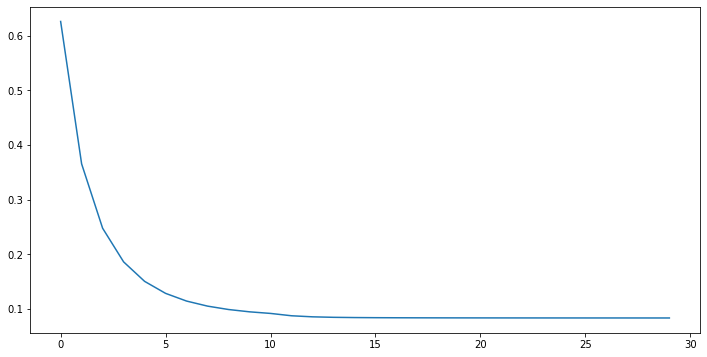

In [22]:
epochs_n = 20
learning_rate = 1e-3
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

for ep in tqdm(range(epochs_n)):
    ep_loss = 0
    pred = model(train)
    loss = criterion(pred, train)

    pred_resid = model(train_resid)
    loss_resid = criterion(pred_resid, train_resid)
    loss = (loss*train_size + loss_resid) / (train_size + 1)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_history.append(loss.item())

    if ep % 5 == 0:
        print(loss.item()) 

print(loss.item()) 
plt.figure(figsize=(12,6))
plt.plot(loss_history[:]) 

In [23]:
def IRE(data, data_resid):
    with torch.no_grad():
        losses = []
        for sample in data:
            pred = model(sample.reshape(1, in_channels, -1))
            chan_loss = []
            for test_it, pred_it in zip(sample, pred[0]):
                loss = criterion(pred_it, test_it)
                chan_loss.append(loss.item())  
            losses.append(np.max(chan_loss))

        pred = model(data_resid)
        chan_loss = []
        for test_it, pred_it in zip(data_resid[0], pred[0]):
            loss = criterion(pred_it, test_it)
            chan_loss.append(loss.item())  
        losses.append(np.max(chan_loss))
    return losses

In [34]:
import seaborn as sns

In [37]:
cor_coefs = np.corrcoef(train_df)

<AxesSubplot:>

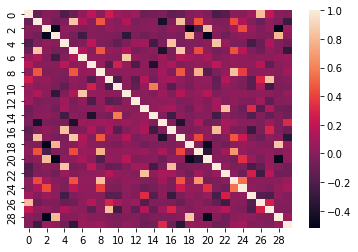

In [38]:
sns.heatmap(cor_coefs)

0.11597824130068493


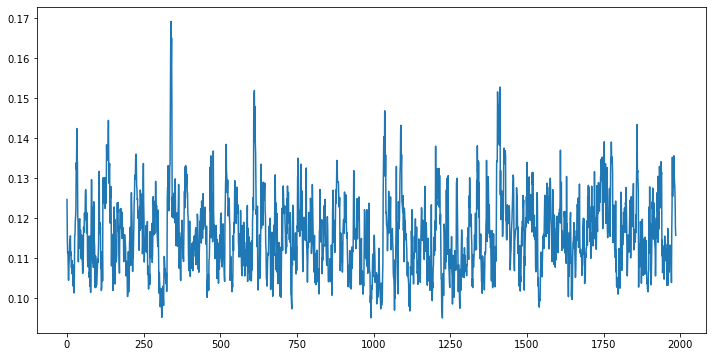

In [29]:
train_loss = IRE(train, train_resid)
plt.figure(figsize=(12,6))
plt.plot(train_loss)
print(np.mean(train_loss)) 

0.11831246897455597


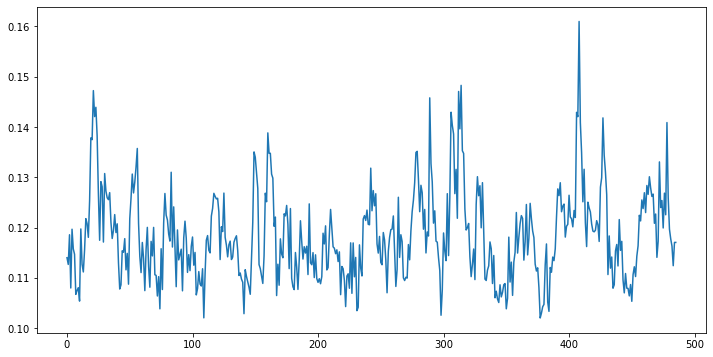

In [30]:
with open('data/{}/valid.pkl'.format(PATH), 'rb') as f:
    valid_np = pickle.load(f)

valid, valid_resid = prep_df(valid_np, in_channels, WIN_SIZE, STRIDE)
valid_size = valid.shape[0]

valid_loss = IRE(valid, valid_resid)
plt.figure(figsize=(12,6))
plt.plot(valid_loss)
print(np.mean(valid_loss)) 
max_valid_er = np.max(valid_loss) 

0.12878369545972562


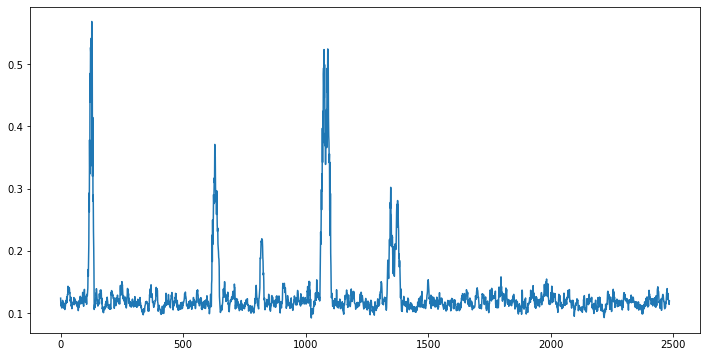

In [31]:
with open('data/{}/test.pkl'.format(PATH), 'rb') as f:
    test_np = pickle.load(f)

with open('data/{}/errors_positions.pkl'.format(PATH), 'rb') as f:
    er_pos = pickle.load(f)

test, test_resid = prep_df(test_np, in_channels, WIN_SIZE, STRIDE)

test_loss = IRE(test, test_resid)
plt.figure(figsize=(12,6))
plt.plot(test_loss)
print(np.mean(test_loss)) 

In [22]:
# fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,16))
# dil = [2,4,8,16]
# for row in range(3):
#     col = 0
#     ser = er_pos.keys()
#     ser = list(ser)[row]
#     for er_start, er_end in er_pos[ser]:
#         ax[row, col].plot(test_np[ser, er_start-50:er_end+50])
#         ax[row, col].set_title('Series {}, dil={}'.format(ser+1, dil[col]))
#         col+=1

In [23]:
# for ser in er_pos:
#     fig, ax = plt.subplots(nrows=1, ncols=len(er_pos[ser]), figsize=(20,4))
#     fig.suptitle('Series {}'.format(ser+1), size=16, weight='bold')
#     col = 0
#     for er_start, er_end in er_pos[ser]:
#         ax[col].plot(test_np[ser, er_start-50:er_end+50])
#         # ax[0, col].set_title('Series {}, dil={}'.format(ser+1, dil[col]))
#         col+=1

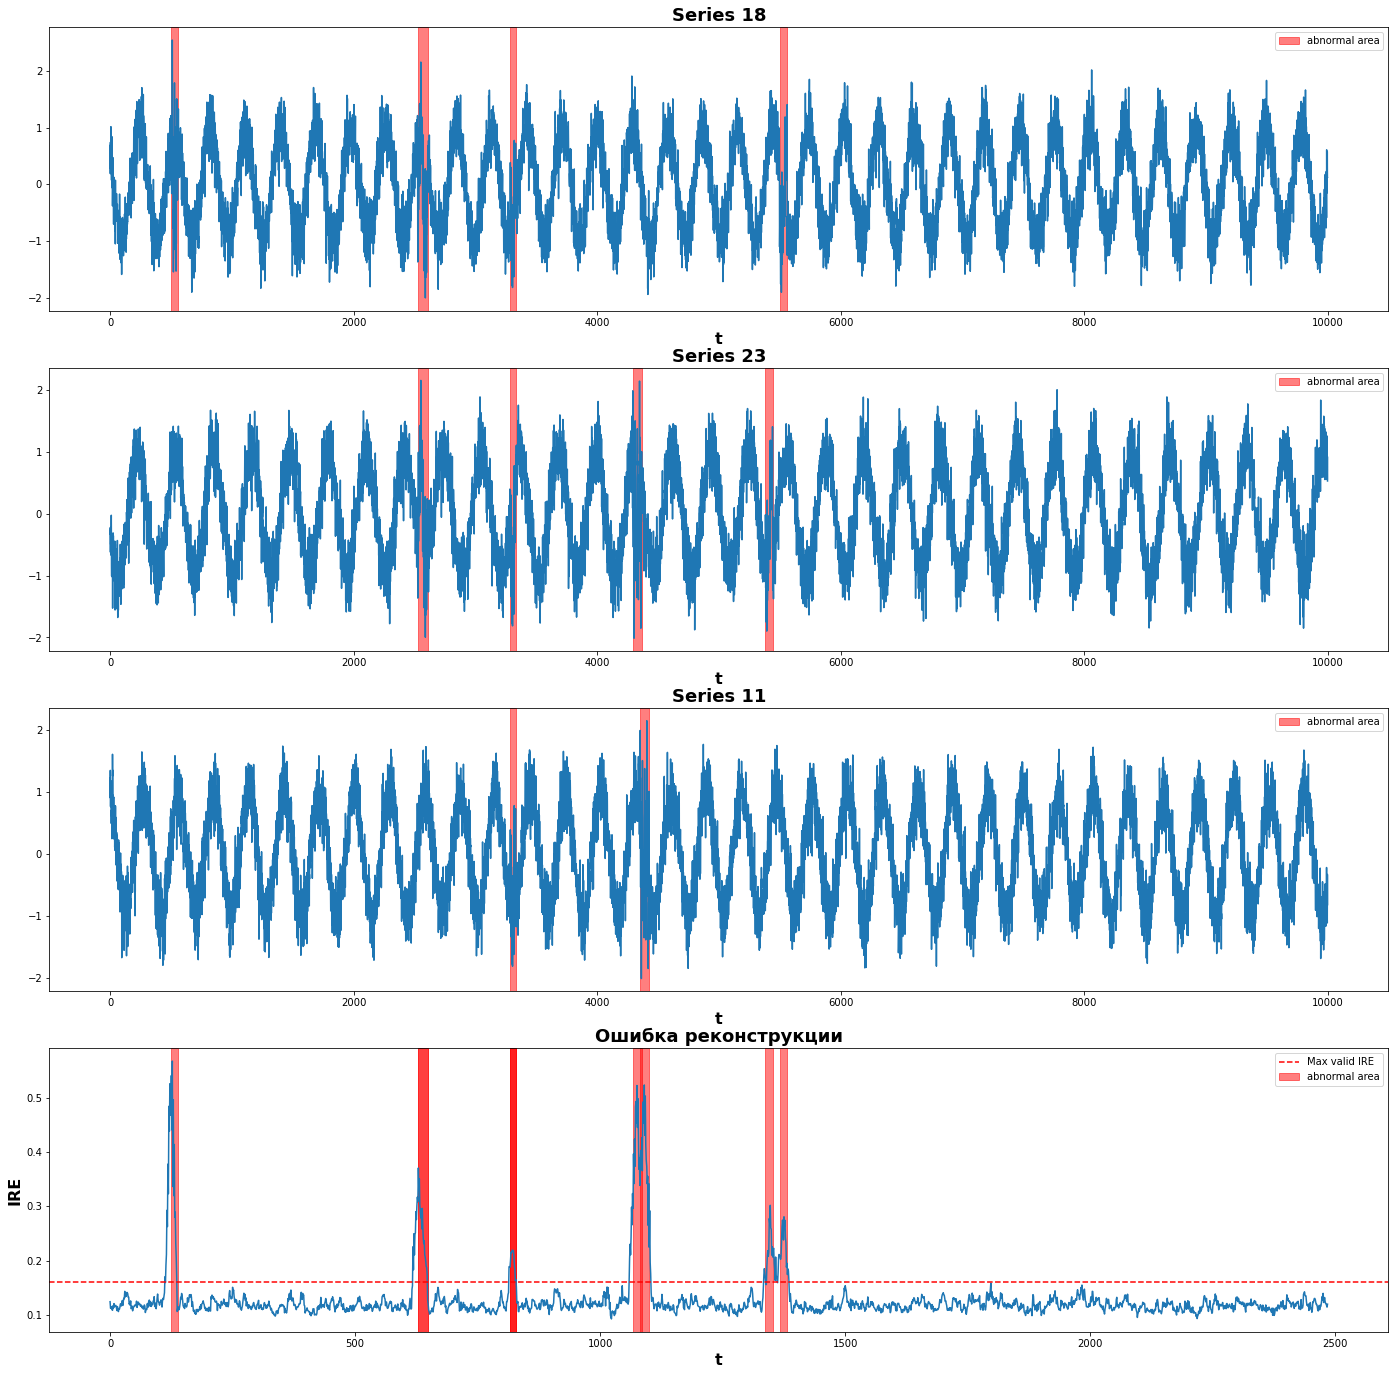

In [38]:
test_size = (test_np.shape[1] - WIN_SIZE)//STRIDE
resid_part = test_np.shape[1] - (test_size*STRIDE) - WIN_SIZE

fig = plt.figure(figsize=(24,24))

# test_np_ct = test_np[:, :99*STRIDE+WIN_SIZE]
test_np_ct = test_np
test_sec_size = test_np_ct.shape[1]
test_loss_size = len(test_loss)
sec_loss_scale = test_sec_size/test_loss_size

ax4 = fig.add_subplot(414)
ax4.plot(test_loss)
ax4.set_title('Ошибка реконструкции', weight='bold',  size=18)

params = {  'color':'red',
            'alpha':0.5 }

for i, ser in enumerate(er_pos):
    ax = fig.add_subplot(411+i)
    ax.plot(test_np_ct[ser])
    ax.set_title('Series {}'.format(ser+1), weight='bold', size=18)
    ax.set_xlabel('t', weight='bold', size=16)
    is_first = True
    for er_start, er_end in er_pos[ser]:
        if i == 0 and is_first:
            ax4.axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, label='abnormal area', **params)
        else:
            ax4.axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, **params)
    
        if is_first:
            ax.axvspan(er_start, er_end, label='abnormal area', **params)
            is_first=False
        else: 
            ax.axvspan(er_start, er_end, **params)

    ax.legend(loc='upper right')


anomaly_border = max_valid_er 
ax4.axhline(anomaly_border, color='r', linestyle='--', label='Max valid IRE') 
ax4.set_xlabel('t', weight='bold', size=16)
ax4.set_ylabel('IRE', weight='bold', size=16)
ax4.legend(loc='upper right')

In [25]:
test, test_resid = prep_df(test_np, in_channels, WIN_SIZE, STRIDE)
b = 0
with torch.no_grad():
    test_losses = []
    for sample in test:
        pred = model(sample.reshape(1, in_channels, -1))
        chan_loss = []
        for test_it, pred_it in zip(sample, pred[0]):
            loss = criterion(pred_it, test_it)
            chan_loss.append(loss.item())  
        test_losses.append(chan_loss)

    pred = model(test_resid)
    chan_loss = []
    for test_it, pred_it in zip(test_resid[0], pred[0]):
        loss = criterion(pred_it, test_it)
        chan_loss.append(loss.item())  
    test_losses.append(chan_loss)
    
test_losses = np.asarray(test_losses)
# plt.figure(figsize=(12,6))
# plt.plot(test_loss)
# print(np.mean(test_loss))

KeyboardInterrupt: 

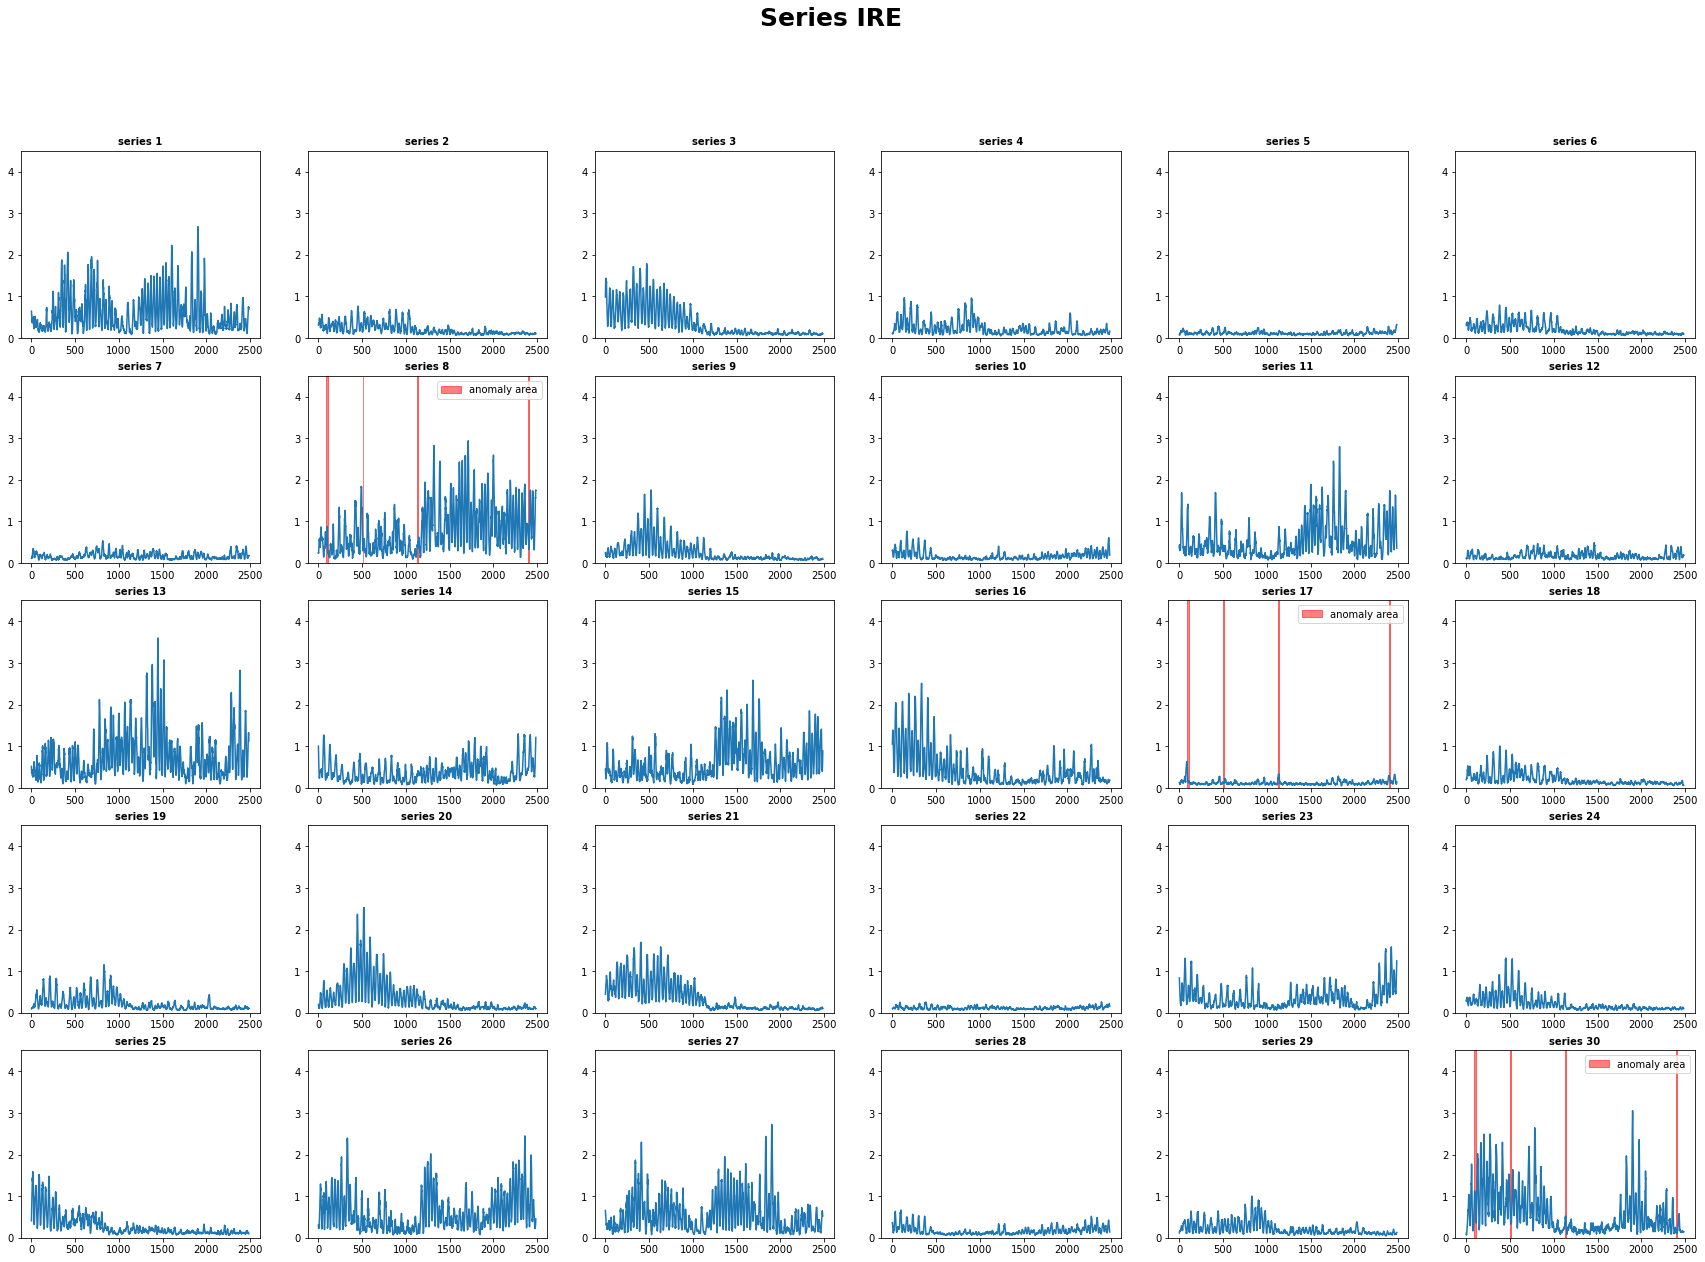

In [27]:
cols = 6
rows = 5
counter = 0 
max_y = np.max(test_loss)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, 20))
fig.suptitle('Series IRE', weight='bold', size=25)
for row in range(rows):
    for col in range(cols):
        ax[row,col].plot(test_losses[:, counter])
        ax[row,col].set_title('series {}'.format(counter+1), weight='bold', size=10)
        ax[row,col].set_ylim([0,max_y*1.25])
        if counter in er_pos:
            is_first = True
            for er_start, er_end in er_pos[counter]:
                if is_first:
                    ax[row,col].axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, label='anomaly area', **params)
                    is_first=False
                else: 
                    ax[row,col].axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, **params)

            ax[row,col].legend(loc='upper right')
            
        counter+=1

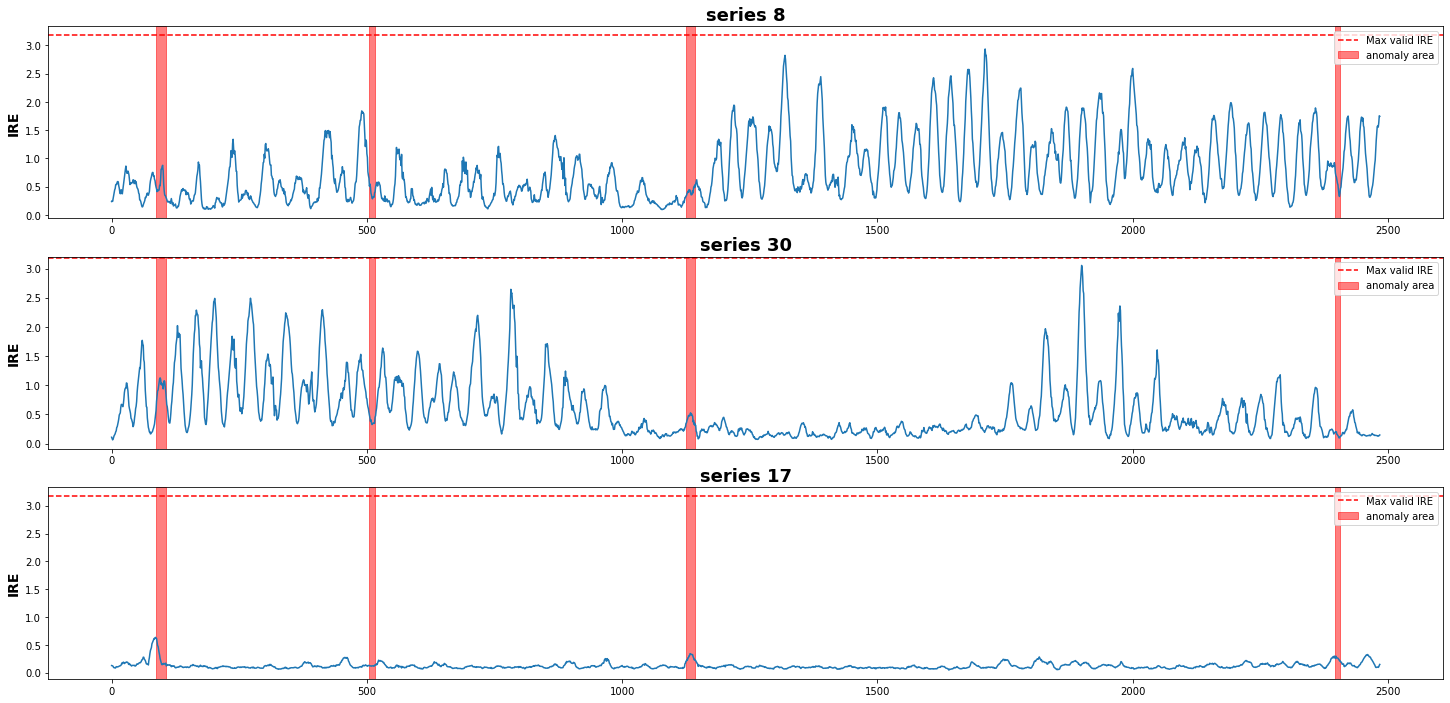

In [28]:
anomaly_border = max_valid_er 

fig = plt.figure(figsize=(25,12))
for i, ser in enumerate(er_pos):
    ax = fig.add_subplot(311+i)

    ax.plot(test_losses[:, ser])
    ax.set_title('series {}'.format(ser+1), weight='bold', size=18)
    ax.axhline(anomaly_border, color='r', linestyle='--', label='Max valid IRE') 
    
    is_first = True
    for er_start, er_end in er_pos[ser]:
        ax.set_ylabel('IRE',  weight='bold', size=14)
        if is_first:
            ax.axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, label='anomaly area', **params)
            is_first=False
        else: 
            ax.axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, **params)
        
    ax.legend(loc='upper right')

In [41]:
torch.save(model.state_dict(), 'saved_models/shift_sim_64_4.pt')

In [3]:
import pickle
PATH = 'dil_sim_test'
with open('data/{}/errors_positions.pkl'.format(PATH), 'rb') as f:
    er_pos = pickle.load(f)

In [4]:
er_pos

{7: array([[ 353,  432],
        [2030, 2072],
        [4529, 4597],
        [9639, 9685]]),
 29: array([[ 353,  432],
        [2030, 2072],
        [4529, 4597],
        [9639, 9685]]),
 16: array([[ 353,  432],
        [2030, 2072],
        [4529, 4597],
        [9639, 9685]])}